$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

*Yinzhi(Aaron) Deng*

*CSU ID: 830888654*

## Overview

In this assignment, you will be modifying the reinforcement learning code used to solve the dynamic marble problem.  You will be solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

## Start with This Code

Download [A5.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A5.tar) and extract its contents, which are

* `marble.py`
* `neuralnetworksbylayer.py`
* `layers.py`
* `scaledconjugategradient.py`
* `mlutils.py`

In [ ]:
!wget http://www.cs.colostate.edu/~anderson/cs480/notebooks/A5.tar
!tar xvf A5.tar

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

To define a reinforcement learning problem, we need functions that return

* initial the state of the environment,
* a next state given a current state and an action,
* a reinforcement value, and
* an action to take, given the current state. For this we define an $\epsilon$-greedy policy.

Let's first define the set of valid actions.  For our simple one-dimensional marble problem, we can push left, right, or not push at all.

In [2]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()), np.random.randint(1,10)])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0,s[2]])
    elif s[0] > 10:
        s = np.array([10,0,s[2]])
    return s

def reinforcement(s):  # s is new state
    #goal = 5
    goal = s[2]
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [3]:
def makeSamples(qnet, nStepsPerStart):
    samples = []
    state = initialState()
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Now we can play.  Define constants we need.

In [4]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace):
    # update
    target = X[0][2]
    
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    #plt.plot([0,X.shape[0]], [5,5],'--',alpha=0.5,lw=5)
    # update
    plt.plot([0,X.shape[0]], [target, target],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    #qs = qnet.use(np.array([[s,0,a] for a in validActions for s in range(11)]))
    # update
    qs = qnet.use(np.array([[s, 0, target,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    #plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    # update
    plt.fill_between([target-1, target+1],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    #qs = qnet.use(np.array([[xsflat[i],ysflat[i],a] for a in validActions for i in range(len(xsflat))]))
    # update
    qs = qnet.use(np.array([[xsflat[i], ysflat[i],target,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial,target=5):
    xs = np.linspace(0,10,nTrials)
    #plt.subplot(4,3,12)
    for x in xs:
        #s = [x,0] ## 0 velocity
        #update
        s = [x, 0, target]
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            #xtrace[step,:] = s
            # update
            xtrace[step,:] = s[:-1]
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        #plt.plot([5,5],[-5,5],'--',alpha=0.5,lw=5)
        #update
        plt.plot([target,target],[-5,5],'--',alpha=0.5,lw=5) ### UPDATE: change the target line
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [6]:
def reasonable_action(qnet, target = 5):
    '''This function is used to test the efficacy of a model'''
    qs = qnet.use(np.array([[s, 0, target,a] for a in validActions for s in range(11)]))
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy (target = %s)" %(target))
    plt.axis("off")

## Optimize the parameters

### 1. original Situation

In [12]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [13]:
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (1, 9), (-1,1)))

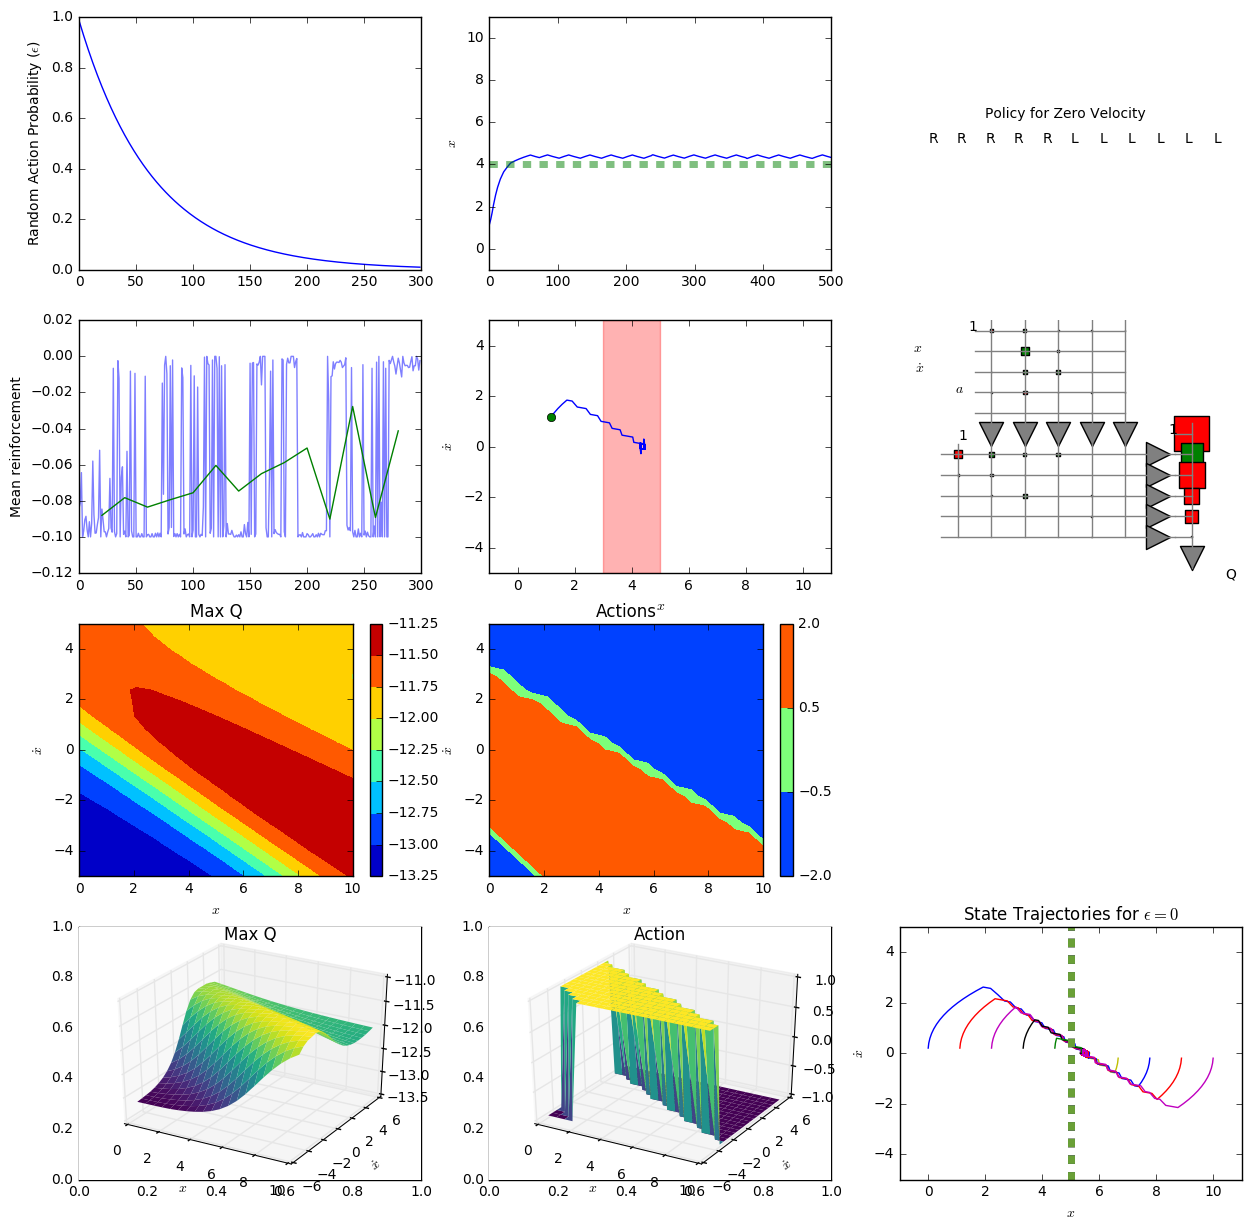

In [14]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
        plt.subplot(4,3,12)
        testIt(qnet,10,500)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

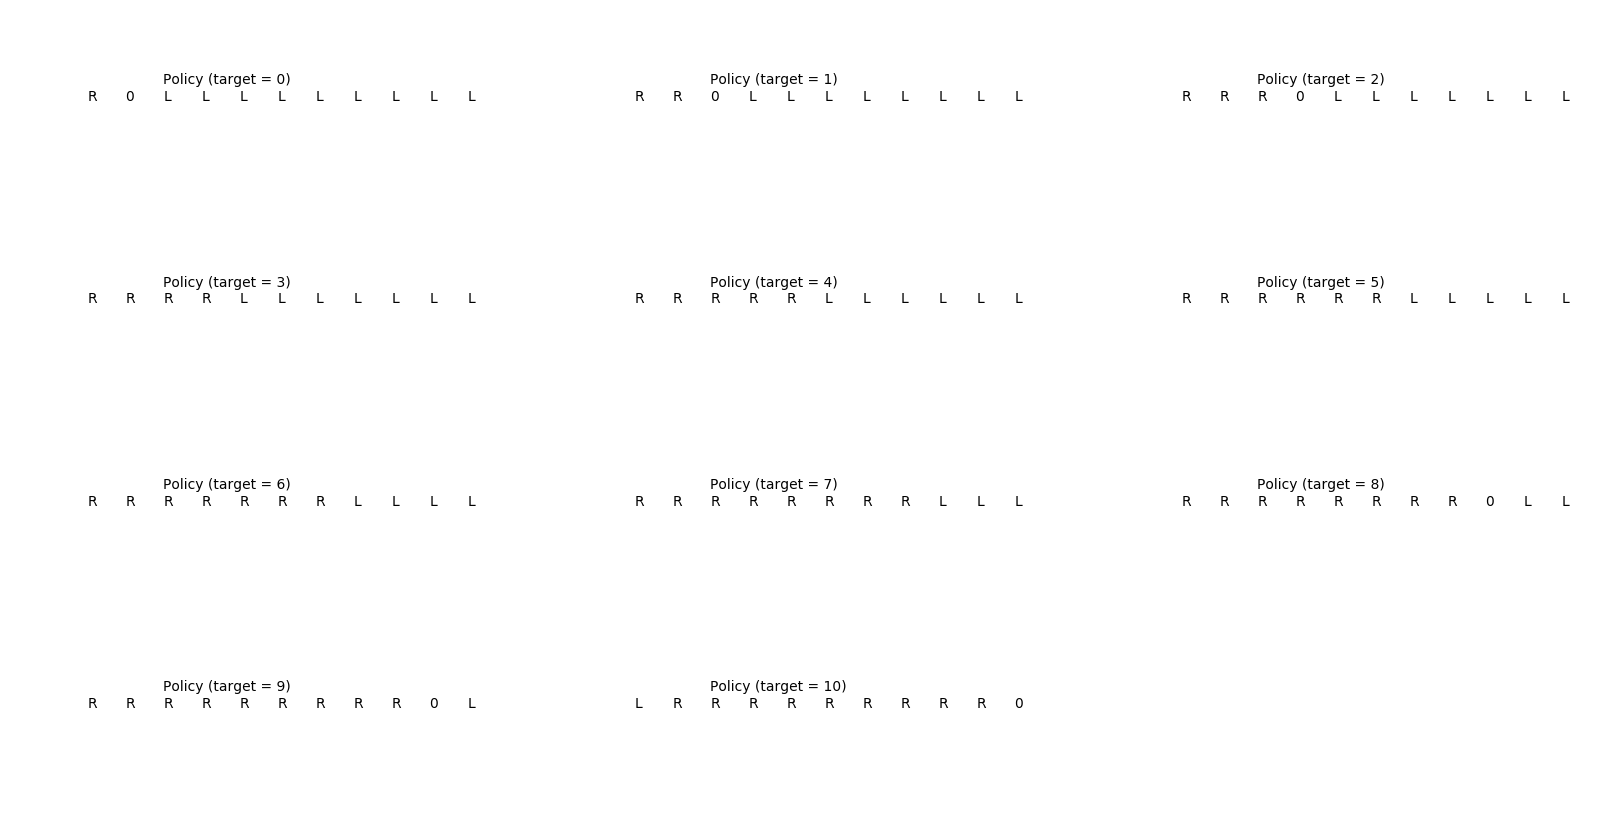

In [15]:
fig = plt.figure(figsize=(20,10))
for i in range(11):
    plt.subplot(4,3,i+1)
    reasonable_action(qnet, i)

Most of the cases are not optimal, only cases(target = 8 and target = 9) are optimal, so we need to optimize the parameters.

### 2. Increase the number of interations

In [16]:
gamma = 0.999
nTrials = 3000
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [17]:
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (1, 9), (-1,1)))

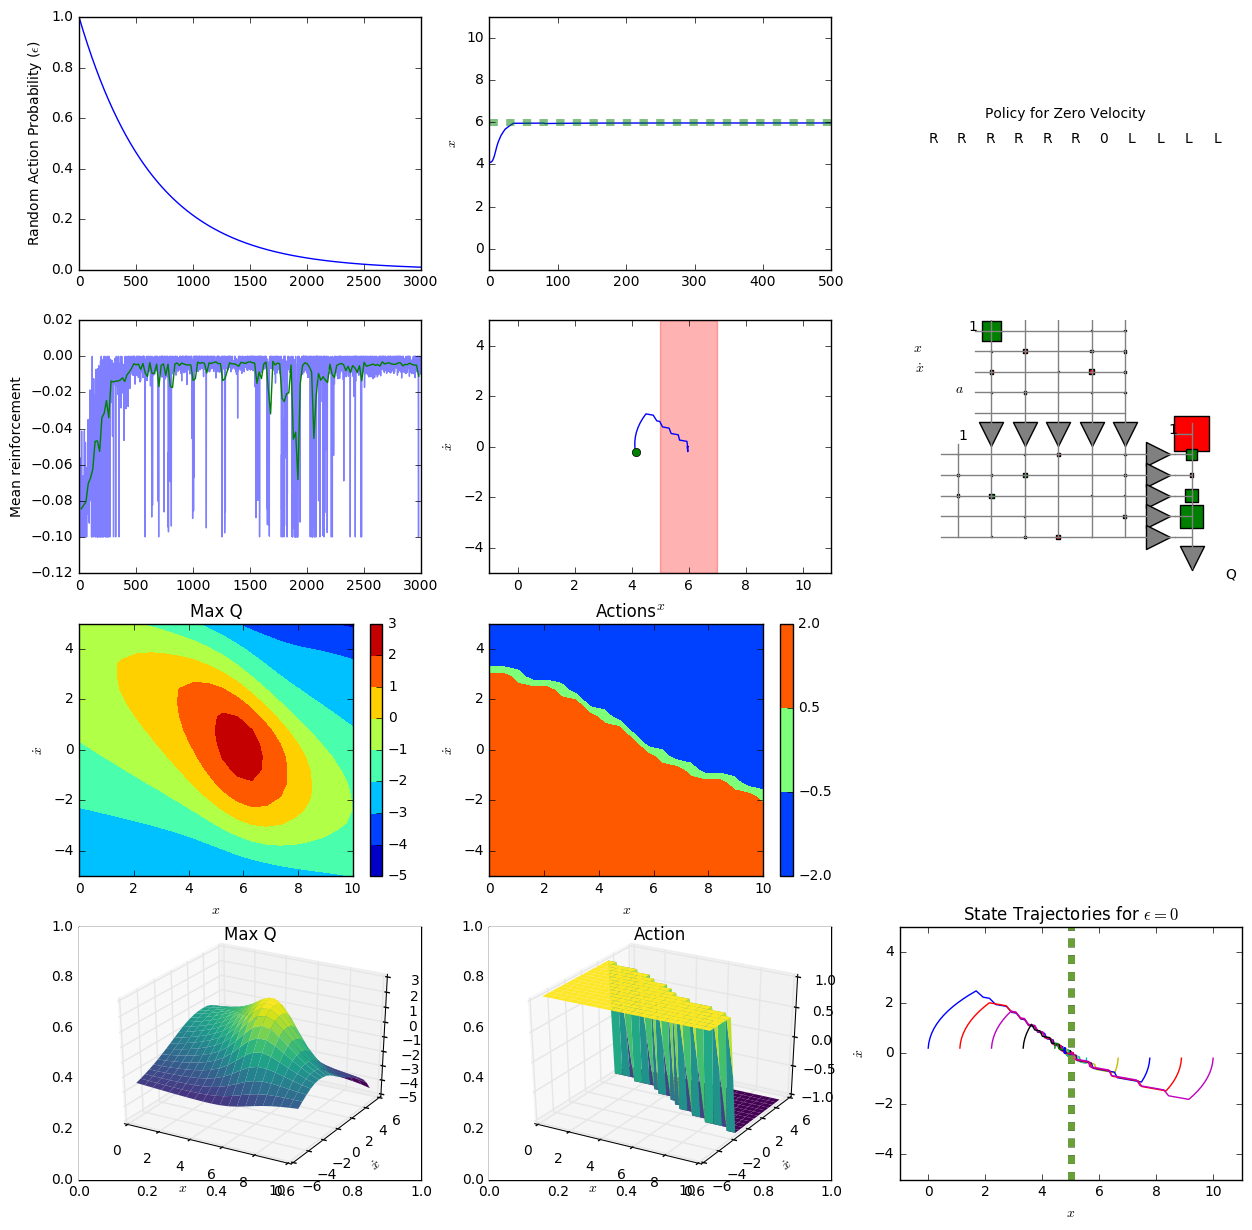

In [18]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
        plt.subplot(4,3,12)
        testIt(qnet,10,500)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

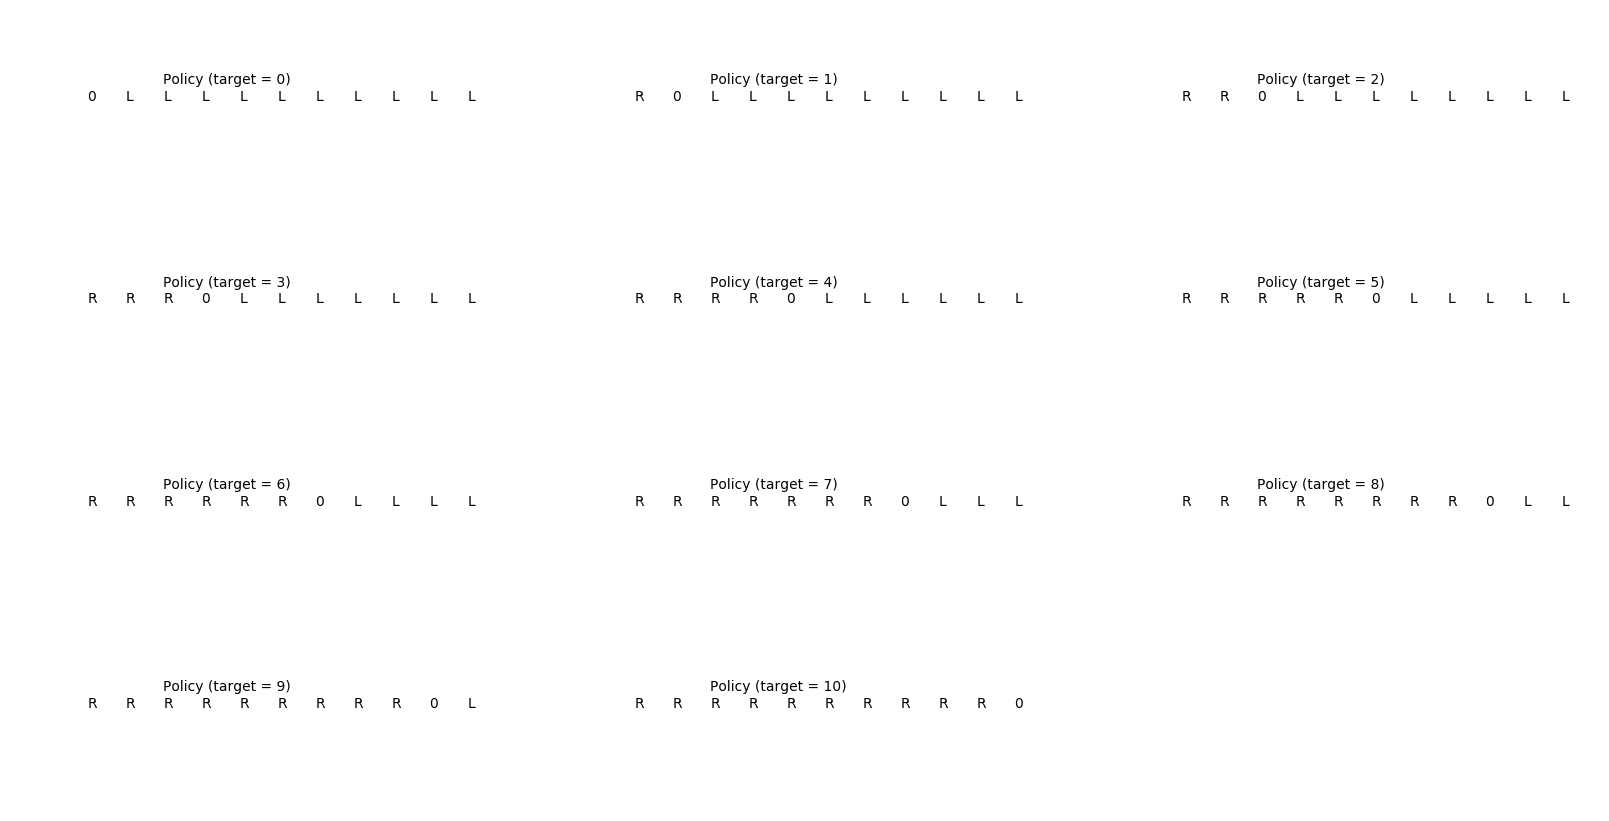

In [19]:
fig = plt.figure(figsize=(20,10))
for i in range(11):
    plt.subplot(4,3,i+1)
    reasonable_action(qnet, i)

After increasing the number of trial from 300 to 3000, the result is perfect of all the cases are optimal.

### 3. Increase the number of steps per trail

In [20]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 1000 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [21]:
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (1, 9), (-1,1)))

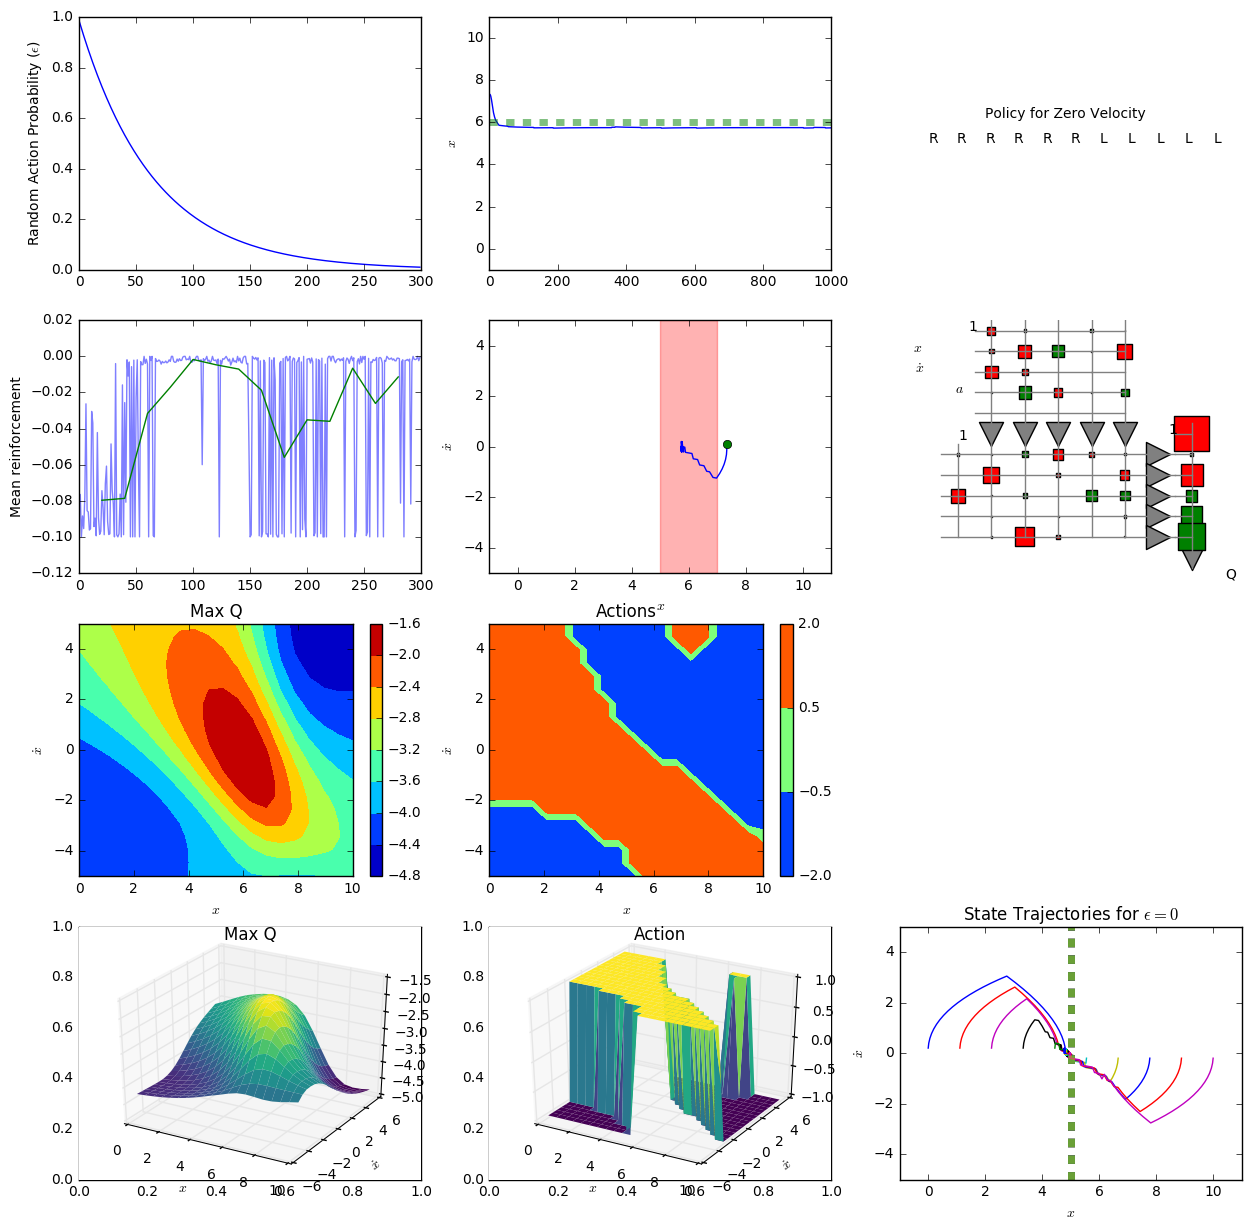

In [22]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
        plt.subplot(4,3,12)
        testIt(qnet,10,500)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

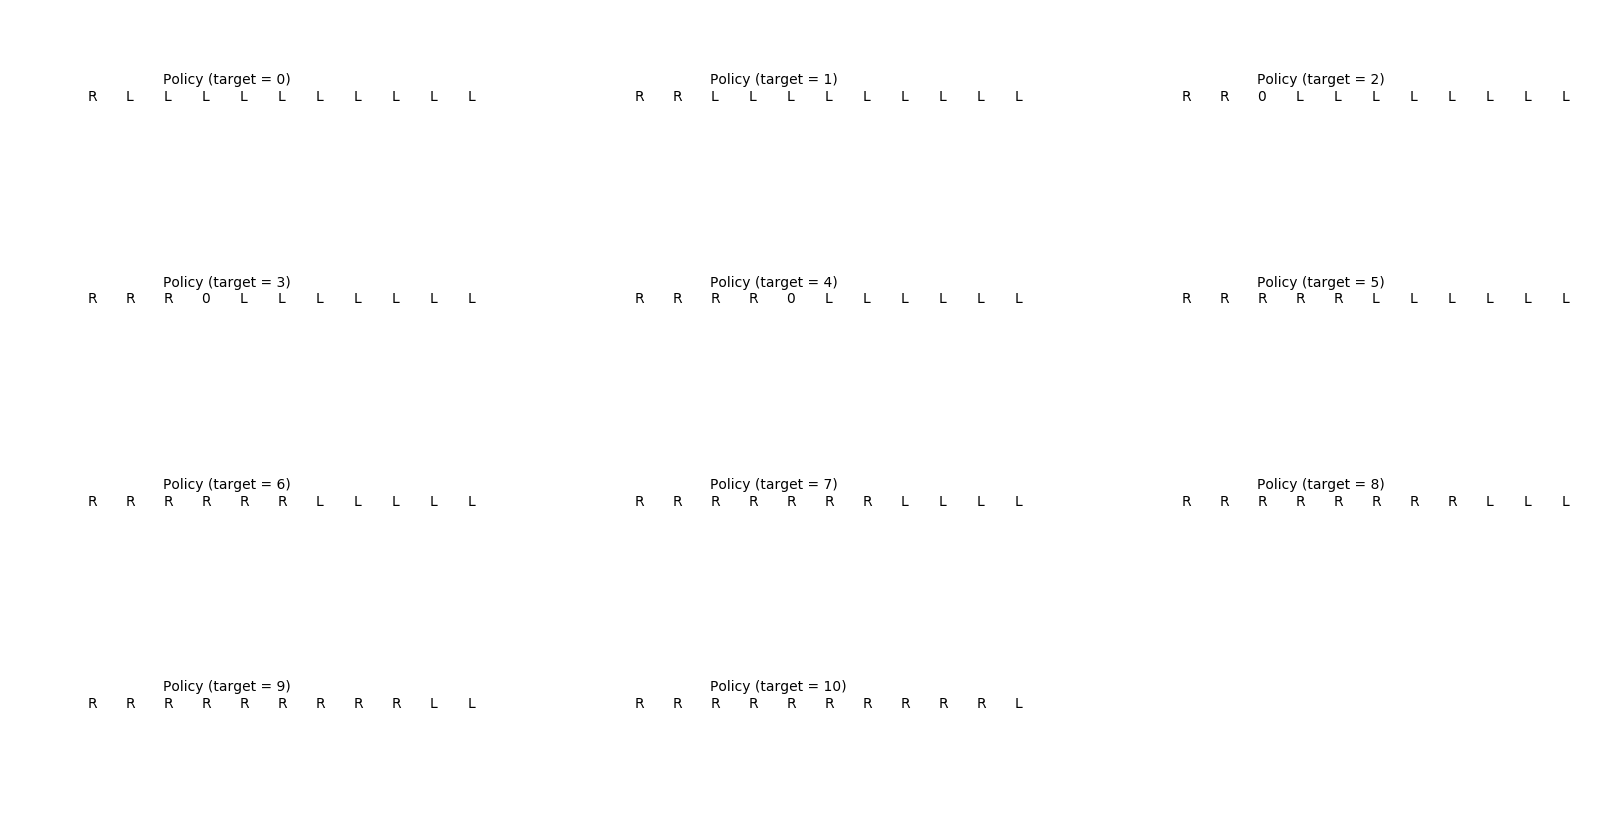

In [23]:
fig = plt.figure(figsize=(20,10))
for i in range(11):
    plt.subplot(4,3,i+1)
    reasonable_action(qnet, i)

This time we trid to increase the number of steps per trail, while the result is not good enough, that only some of the cases are optimal. So, we know that increasing the number of trails is a better optimization method.

## Plots of different goals

### 1. Trejectories of goals of 1, 5, 9

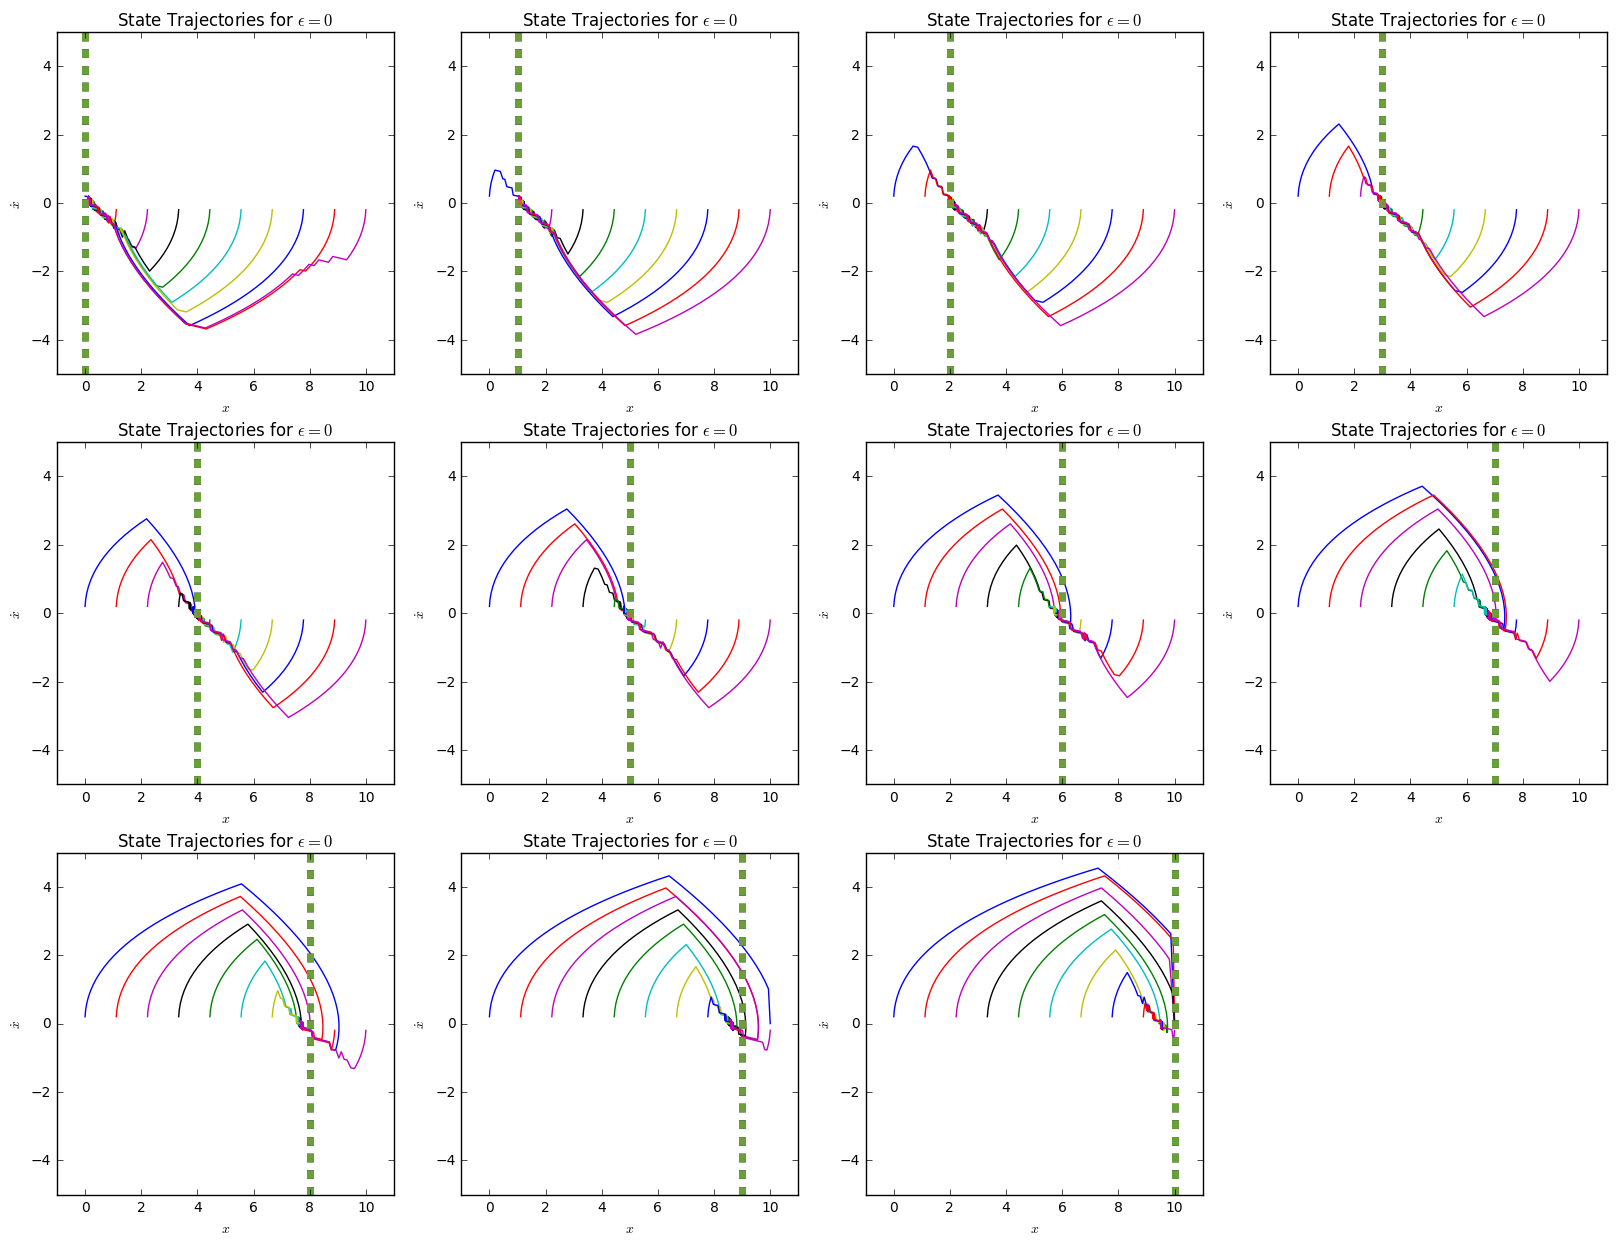

In [48]:
fig = plt.figure(figsize=(20,15))
for i in range(11):
    plt.subplot(3,4,i+1)
    testIt(qnet, 10, 500, target = i)

From the plots of goals of 1, 5, 9, it is obvious that if the marble is farer from the target, it will move faster. And if it is near the target, it will move slowly.

### 2. MaxQ (Contour) of goals of 1, 5, 9

In [46]:
def maxQ_contour(qnet, target = 5):
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i], ysflat[i],target,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q, target = %i" %(target))

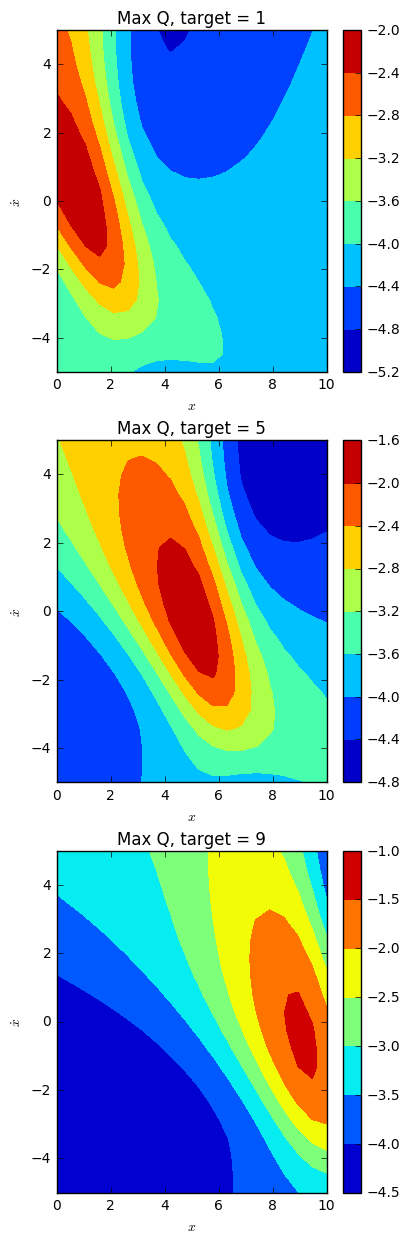

In [47]:
fig = plt.figure(figsize=(20,15))
for i in (1, 5, 9):
    plt.subplot(3,4,i+1)
    maxQ_contour(qnet, i)

According to these plots, we found that the max Q values are always appear near positions of targets on the x-axis.

### 3. MaxQ (Surface) of goals of 1, 5, 9

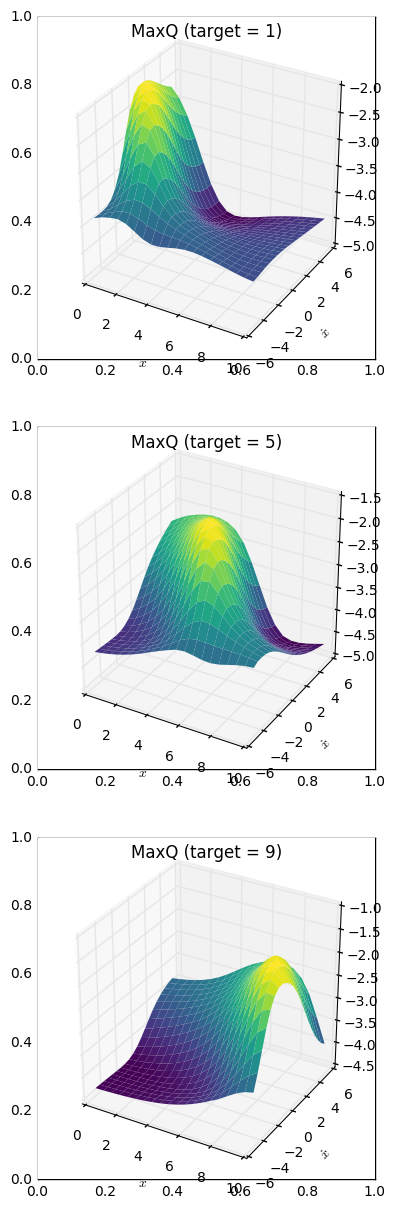

In [63]:
fig = plt.figure(figsize=(20,15))
for ii in (1,5,9):
    s = plt.subplot(3,4,ii+1)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i], ysflat[i],ii,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
#     s = plt.subplot(3,4,ii+1)
#     rect = s.get_position()
#     ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("MaxQ (target = %s)" %(ii))

From the maxQ surface plots, we found that the waves appear at the position of the x near target values.

### 4. Action (Contour) of goals of 1, 5, 9

In [64]:
def action_contour(qnet, target = 5):
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i], ysflat[i],target,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions (target = %s)" %(target))

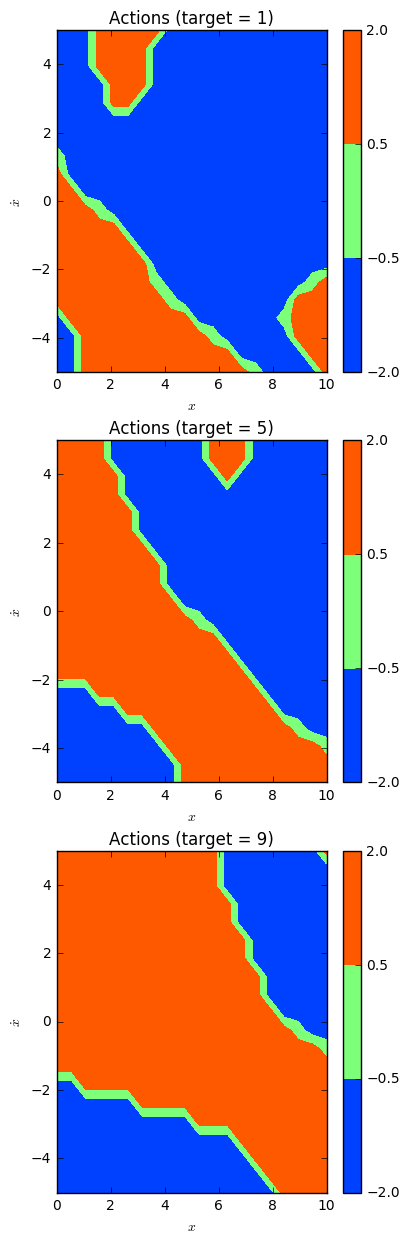

In [66]:
fig = plt.figure(figsize=(20,15))
for i in (1, 5, 9):
    plt.subplot(3,4,i+1)
    action_contour(qnet, i)

From these plots, we know that when the marble is on the left of the target, it should move right, that is represented as the red area which means position speed. And on the contrary, if it is on the right of the target, it should move left, that is represented as the blue area which means negative speed on the plots.

## Conclusion

First, if the networks contains the parameter of the goals, it will need more iterations to train itself to achieve the best parameter set.

The best parameters are:

gamma = 0.999

nTrials = 3000

nStepsPerTrial = 500 

nSCGIterations = 30

finalEpsilon = 0.01

## Extra Credit

One point of extra credit will be given for completing each of the following things. These points will be used at the end of the semester to add to your semester average and possibly bump up your letter grade.

* Change the marble's world from one dimension to two. Add graphs of the marble's movement in the two-dimensional plan.
* Increase the number of valid actions from three to seven.
* Add a variable wind as a force on the marble, along with another state variable that indicates wind speed and direction.
* Add a second marble with its own RL agent.  Add negative reinforcement if they bump into each other.
* Add areas of increased friction to the track.

For all of these, demonstrate the effects and write about what you observe.